# Image alignment

In this task, we will have to solve two image alignment problems: channel processing and face alignment.

# Image channels processing and alignment 

## Problem review

Sergey Prokudin-Gorsky was the first color photographer in Russia, who made the color portrait of Leo Tolstoy. Each of his photographs is three black-and-white photo plates, corresponding to red, green, and blue color channels. Currently, the collection of his pictures is situated in the U.S. Library of Congress, the altered versions have proliferated online. In this task, you should make a programme which will align the images from the Prokudin-Gorsky plates and learn the basic image processing methods.

In [1]:
!pip install opencv-python

In [2]:
!pip install scikit-image

In [3]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import os
import pickle
import math
from skimage.feature import canny
from skimage import filters
from skimage.transform import rotate
import skimage.transform as tf
from scipy import ndimage

Populating the interactive namespace from numpy and matplotlib


## Problem description

#### Input image loading

The input image is the set of 3 plates, corresponding to B, G, and R channels (top-down). We should implement the function $\tt{load}$\_$\tt{data}$ that reads the data and returns the list of images of plates.
$\tt{dir}$\_$\tt{name}$ is the path to the directory with plate images. If this directory is located in the same directory as this notebook, then default arguments can be used.

In [4]:
def load_data(dir_name='plates'):
    img_list = []
    for image in os.listdir(dir_name):
        print(image)
        img=plt.imread(dir_name+'/'+image)
        #img = cv2.imread(os.path.join(dir_name,filename),0)
        plt.imshow(img)
        plt.show()
        img_list.append(img[:,:,0])
    return np.array(img_list)

1.png


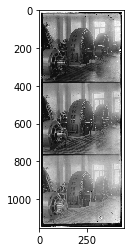

2.png


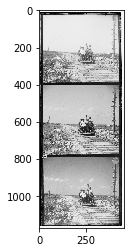

3.png


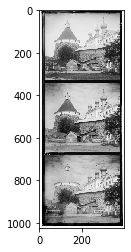

4.png


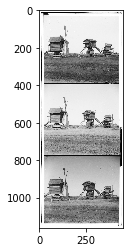

5.png


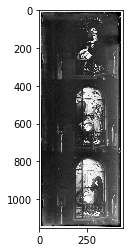

6.png


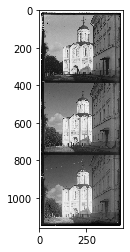

In [5]:
plates = load_data()

In [6]:
plates[0].shape

(1153, 448)

The dataset is a list of 2-dimensional arrays.

In [7]:
# The auxiliary function `visualize()` displays the images given as argument.
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        elif img.shape[1] == 3:
            img = img.transpose(2,0,1)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

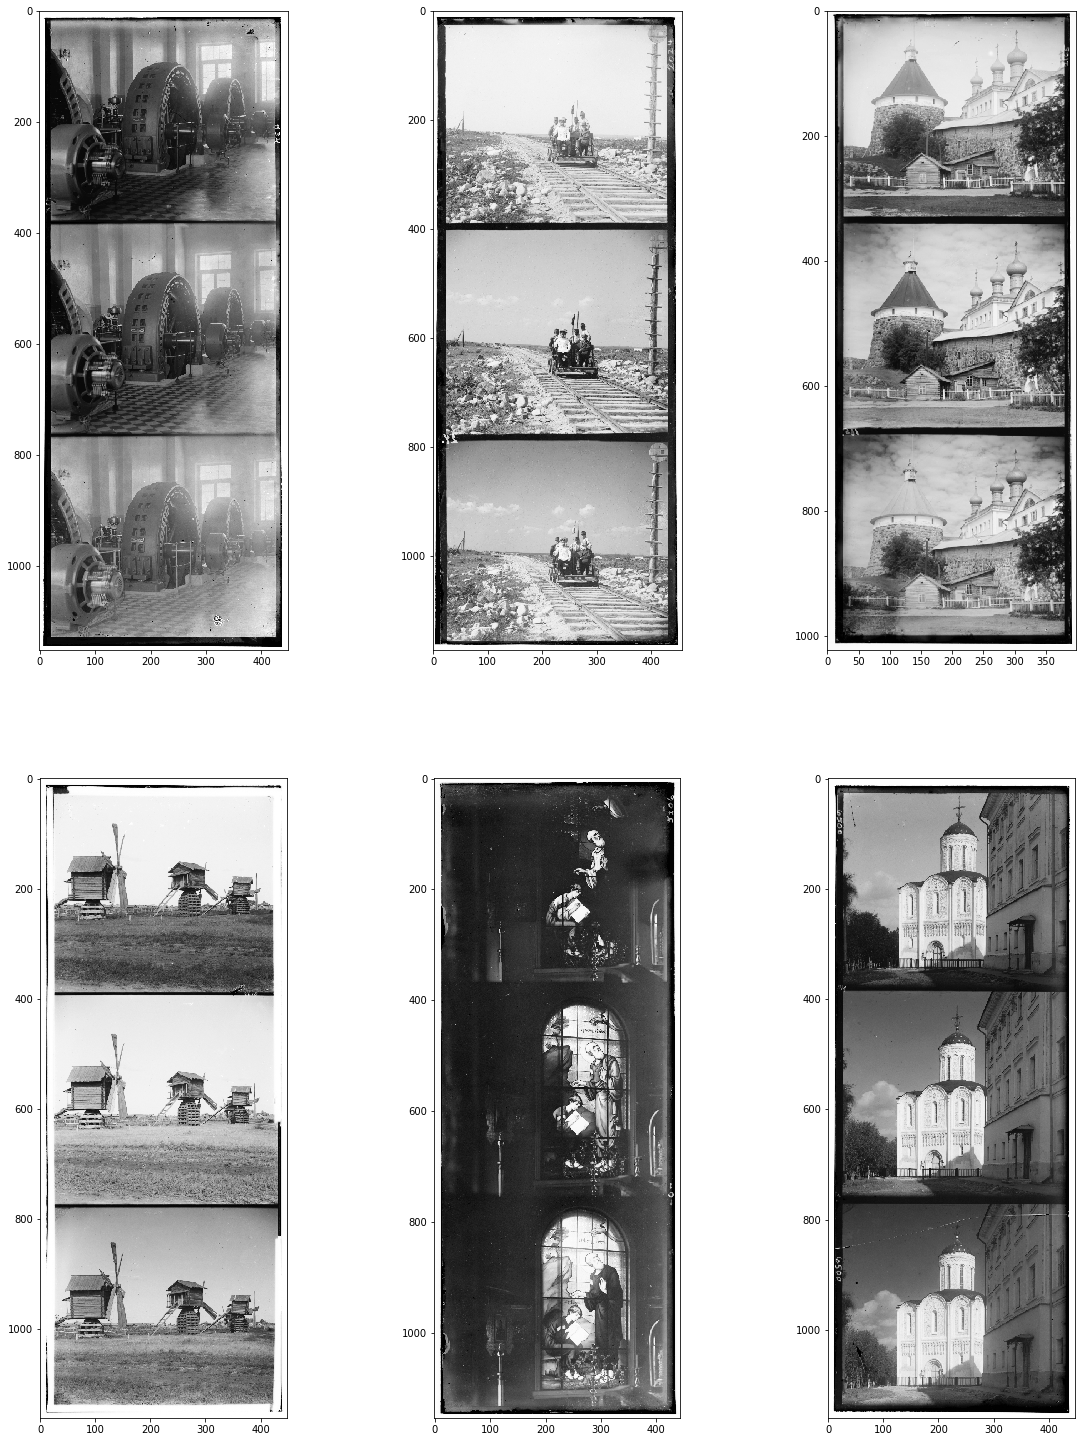

In [8]:
visualize(plates, 'gray')

#### The borders removal 
It is worth noting that there is a framing from all sides in most of the images. This framing can appreciably worsen the quality of channels alignment. Here, we should find the borders on the plates using Canny edge detector, and crop the images according to these edges. The example of using Canny detector implemented in skimage library can be found [here](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html).<br>

The borders can be removed in the following way:
* Apply Canny edge detector to the image.
* Find the rows and columns of the frame pixels. 
For example, in case of upper bound we will search for the row in the neighborhood of the upper edge of the image (e.g. 5% of its height). For each row let us count the number of edge pixels (obtained using Canny detector) it contains. Having these number let us find two maximums among them. Two rows corresponding to these maximums are edge rows. As there are two color changes in the frame (firstly, from light scanner background to the dark tape and then from the tape to the image), we need the second maximum that is further from the image border. The row corresponding to this maximum is the crop border. In order not to find two neighboring peaks, non-maximum suppression should be implemented: the rows next to the first maximum are set to zero, and after that, the second maximum is searched for.

#### Canny detector implementation 
We can write our own implementation of Canny edge detector to get extra points. <br>

Canny detection algorithm:
1. *Noise reduction.* To remove noise, the image is smoothed by Gaussian blur with the kernel of size $5 \times 5$ and $\sigma = 1.4$. Since the sum of the elements in the Gaussian kernel equals $1$, the kernel should be normalized before the convolution. <br><br>

2. *Calculating gradients.* When the image $I$ is smoothed, the derivatives $I_x$ and $I_y$ w.r.t. $x$ and $y$ are calculated. It can be implemented by convolving $I$ with Sobel kernels $K_x$ and $K_y$, respectively: 
$$ K_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}, K_y = \begin{pmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{pmatrix}. $$ 
Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated:
$$ |G| = \sqrt{I_x^2 + I_y^2}, $$
$$ \theta(x,y) = arctan\left(\frac{I_y}{I_x}\right)$$<br><br>

3. *Non-maximum suppression.* For each pixel find two neighbors (in the positive and negative gradient directions, supposing that each neighbor occupies the angle of $\pi /4$, and $0$ is the direction straight to the right). If the magnitude of the current pixel is greater than the magnitudes of the neighbors, nothing changes, otherwise, the magnitude of the current pixel is set to zero.<br><br>

4. *Double threshold.* The gradient magnitudes are compared with two specified threshold values, the first one is less than the second. The gradients that are smaller than the low threshold value are suppressed; the gradients higher than the high threshold value are marked as strong ones and the corresponding pixels are included in the final edge map. All the rest gradients are marked as weak ones and pixels corresponding to these gradients are considered in the next step.<br><br>

5. *Edge tracking by hysteresis.* Since a weak edge pixel caused from true edges will be connected to a strong edge pixel, pixel $w$ with weak gradient is marked as edge and included in the final edge map if and only if it is involved in the same blob (connected component) as some pixel $s$ with strong gradient. In other words, there should be a chain of neighbor weak pixels connecting $w$ and $s$ (the neighbors are 8 pixels around the considered one). You are welcome to make up and implement an algorithm that finds all the connected components of the gradient map considering each pixel only once.  After that, we can decide which pixels will be included in the final edge map (this algorithm should be single-pass, as well).

09.23.2020

#################################################################

TODO: 

implement Canny detector yourself.                     
We can use methods from scipy.ndimage if we need.     

#################################################################

Our implementation instead of skimage 

In [9]:
#edge label: 0=no edge, 1=soft pixel, 2= unprocessed hard edge pixel, 3=already processed
def find_edges(img,row,col,freq):

    move_range=[-1, 0, 1]
    
    if img[row][col]==2:
        img[row][col]=3
        freq[row][col]+=1
        
    for dr in move_range:
        for dc in move_range:
            if dr==0 and dc==0:
                continue
            if row+dr>=img.shape[0] or col+dc>=img.shape[1] or row+dr<0 or col+dc<0:
                continue
            if img[row+dr][col+dr]==1:
                img[row+dr][col+dr]=2
                img=find_edges(img,row+dr,col+dc,freq)
    return img

In [10]:
def Canny_detector(img):
    
    #  Gaussian blur for noise reduction
    print('\tgaussian blur...\n')
    blurimg=ndimage.gaussian_filter(img, sigma=1.4)
    print('\t--------------------------------------')
    
    #  Gradient calculation
    print('\tgradient cal...\n')
    K_x=np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    K_y=np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])
    
    print('\t\tpicture shape:',img.shape,'\n')
    I_x=ndimage.convolve(img.astype(float32),K_x)
    I_y=ndimage.convolve(img.astype(float32),K_y)
    print('\t\tI_x shape:',I_x.shape,'I_y shape:',I_y.shape,'\n')
    
    G=np.hypot(I_x,I_y)
    print('\t\tG shape:',G.shape,'\n')
    
    T=np.arctan2(I_y,I_x+1e-10)
    print('\t\tT shape:',T.shape,'\n')
    print('\t-------------------------------------')
    
    #  Non-maximum suppression
    print('\tnon-maximum suppression...\n')
    r_max, c_max=blurimg.shape
    blurimg[0,:]=0
    blurimg[:,0]=0
    blurimg[r_max-1,:]=0
    blurimg[:,c_max-1]=0
    PIby8=np.divide(np.pi,6) # 30 degrees per segment
    for row in range(1,r_max-1):
        for col in range(1,c_max-1):
            if (T[row][col]<PIby8) and (T[row][col]>-1*PIby8): #[-30, 30] move along rows, columns fixed
                r_n1,c_n1=(row+1,col)
                r_n2,c_n2=(row-1,col)
            elif (T[row][col]<3*PIby8) and (T[row][col]>PIby8): #[30, 90]
                r_n1,c_n1=(row+1,col+1)
                r_n2,c_n2=(row-1,col-1)
            elif (T[row][col]<5*PIby8) and (T[row][col]>3*PIby8): #[90, 150] move along columns, rows fixed
                r_n1,c_n1=(row,col+1)
                r_n2,c_n2=(row,col-1)
            elif (T[row][col]<7*PIby8) and (T[row][col]>5*PIby8): #[150, 210]
                r_n1,c_n1=(row-1,col+1)
                r_n2,c_n2=(row+1,col-1)
            elif (T[row][col]<-7*PIby8) and (T[row][col]>7*PIby8): #[210, -210] move along rows, columns fixed
                r_n1,c_n1=(row-1,col)
                r_n2,c_n2=(row+1,col)          
            elif (T[row][col]<-5*PIby8) and (T[row][col]>-7*PIby8): #[-210, -150]
                r_n1,c_n1=(row-1,col-1)
                r_n2,c_n2=(row+1,col+1)
            elif (T[row][col]<-3*PIby8) and (T[row][col]>-5*PIby8): #[-150, -90] move alone columns, rows fixed
                r_n1,c_n1=(row,col-1)
                r_n2,c_n2=(row,col+1)
            elif (T[row][col]<-1*PIby8) and (T[row][col]>-3*PIby8): #[-90, -30]
                r_n1,c_n1=(row+1,col-1)
                r_n2,c_n2=(row-1,col+1)
                
            if (G[row][col]<G[r_n1][c_n1]) or (G[row][col]<G[r_n2][c_n2]):
                G[row][col]=0.       
    print('\t-------------------------------------')
               
    #  Double thresholds
    print('\tdouble thresholds...\n')
    normG = np.divide(G,np.max(G))
    T_h=0.25
    T_l=0.05
    blurimg[G<T_l]=0
    blurimg[G>=T_h]=2
    blurimg[(G>=T_l) & (G<T_h)]=1
    print('\t-------------------------------------')
    
    #  Edge continuity through hysteresis
    print('\thysteresis...\n')
    freq=np.zeros(blurimg.shape)
    for row in range(1,r_max-1):
        for col in range(1,c_max-1):
            if blurimg[row][col]==2:
                blurimg=find_edges(blurimg,row,col,freq)
                
    blurimg[blurimg==1]=0
    blurimg[blurimg>0]=255
    
    return blurimg

canny detector starts working...

*************************************
picture # 1 :

*************************************
	gaussian blur...

	--------------------------------------
	gradient cal...

		picture shape: (1153, 448) 

		I_x shape: (1153, 448) I_y shape: (1153, 448) 

		G shape: (1153, 448) 

		T shape: (1153, 448) 

	-------------------------------------
	non-maximum suppression...

	-------------------------------------
	double thresholds...

	-------------------------------------
	hysteresis...

*************************************
picture # 2 :

*************************************
	gaussian blur...

	--------------------------------------
	gradient cal...

		picture shape: (1173, 457) 

		I_x shape: (1173, 457) I_y shape: (1173, 457) 

		G shape: (1173, 457) 

		T shape: (1173, 457) 

	-------------------------------------
	non-maximum suppression...

	-------------------------------------
	double thresholds...

	-------------------------------------
	hysteresis...

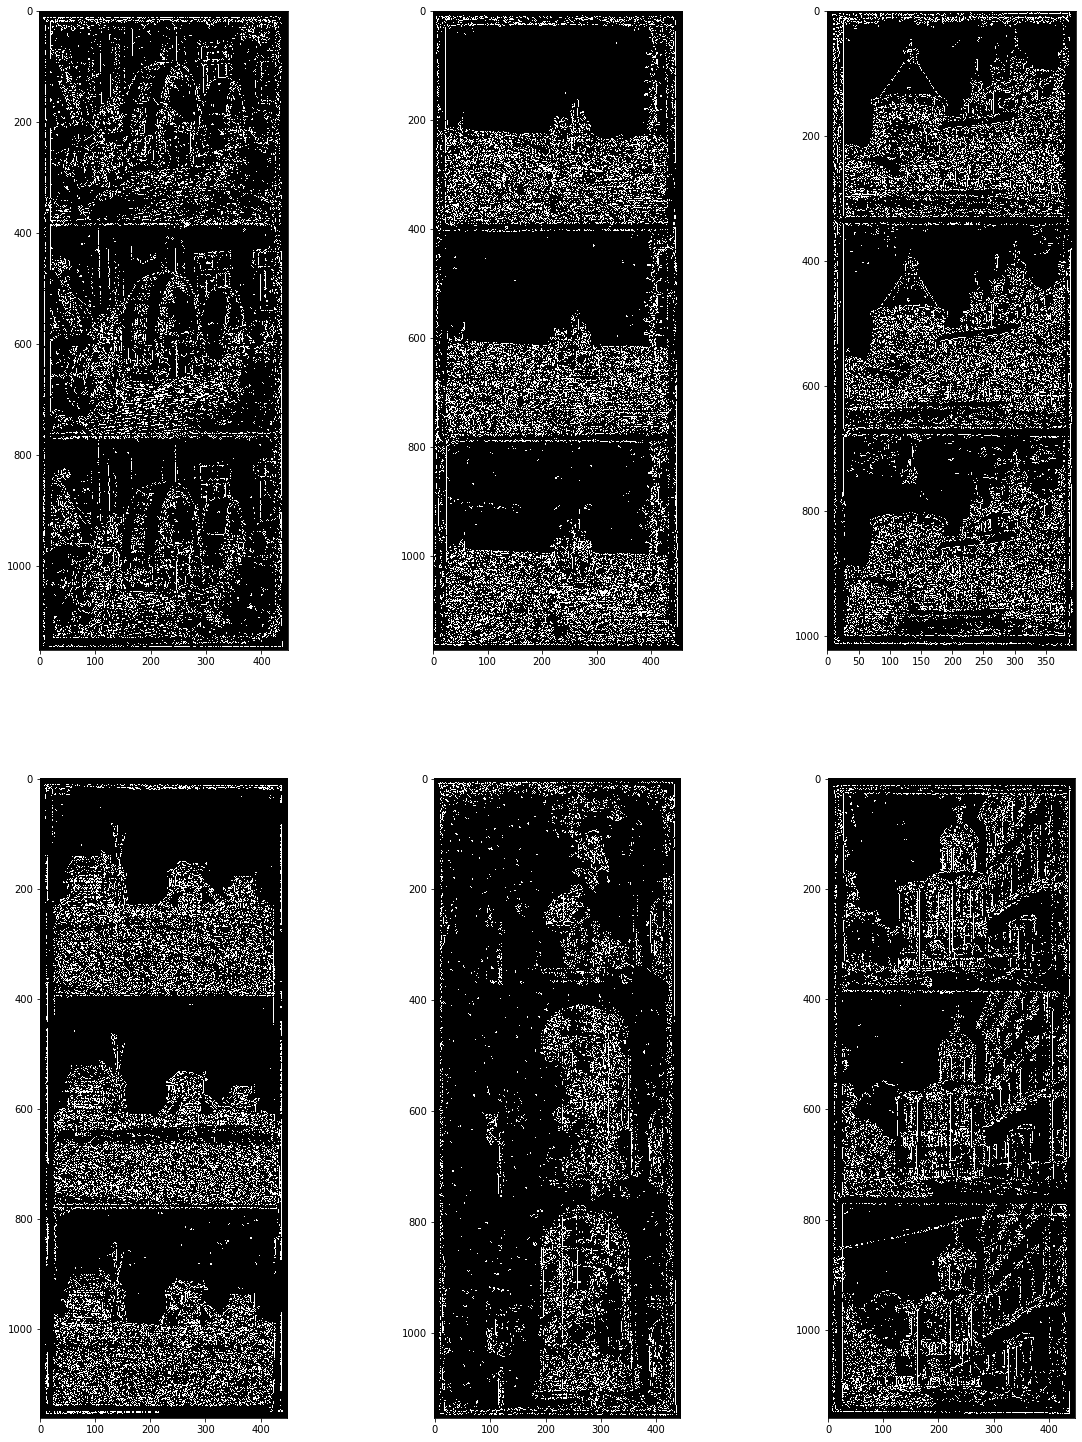

In [11]:
print('canny detector starts working...\n')
canny_imgs = []
count=0
for img in plates:
    count+=1
    print('*************************************')
    print('picture #',count,':\n')
    print('*************************************')
    canny_img = Canny_detector(img)
    canny_imgs.append(canny_img)
    
visualize(canny_imgs, 'gray')

09.24.2020

#################################################################

TODO: 

Implement the removal of the tape borders using         
the output of Canny edge detector ("canny_img" list)    

#################################################################

In [12]:
def find_borders(patch, align, ul2lr):
    
    # align=0, horizontal; =1, vertical
    # ul2dr=0, up/left;    =1, down/right
    
    loc=1
    threshold=0.8
    row, col = patch.shape
    #print(row,col)
    
    if align==0: # from `left` down to `right` (horizontal) 
        tmp_img=np.copy(patch)
        tmp_img[tmp_img>128]=1
        count=np.sum(tmp_img,axis=1,dtype=int64)
        #print('\t',count.shape)
        count=np.reshape(count,(count.shape[0],1))
        #print('\tcount (LR) re-shape:',count.shape)
        count[count>threshold*np.max(count)]=-1
        
        for row in range(count.shape[0]):
            if count[row,0]==-1:
                loc=row
                if ul2lr==1: # from `left` down to `right` (reach to `right`)
                    break
                    
    elif align==1: # from the `upside` `down`
        tmp_img=np.copy(patch)
        tmp_img[tmp_img>128]=1
        count=np.sum(tmp_img,axis=0,dtype=int64)
        #print('\t',count.shape)
        count=np.reshape(count,(1,count.shape[0]))
        #print('\tcount (UD) shape:',count.shape)
        count[count>threshold*np.max(count)]=-1
        
        for col in range(count.shape[1]):
            if count[0,col]==-1:
                loc=col
                if ul2lr==1: # from the `upside` `down` (reach to `down`)
                    break
                    
    return max(loc,1)

In [13]:
def find_bordersV2(patch, label):
    "returns 1st maximal index on top/left and 2nd maximal index on bottom/right"
    
    first_max=max(patch)
    #print('1st max:',np.where(patch==first_max))
    patch_1=np.where(patch==first_max)
    first_max_index=np.where(patch==first_max)[0][0]
    print('1st max index:',first_max_index)
    patch[first_max_index-10:first_max_index+10]=0
    second_max=max(patch)
    #print('2nd max:',np.where(patch==second_max))
    second_max_index=np.where(patch==second_max)[0][0]
    print('2nd max index:',second_max_index)
    
    if label=='higher': # top / left
        return max(first_max_index,second_max_index)
    elif label=='lower': # bottom / right
        return min(first_max_index,second_max_index) - patch.shape[0]

In [14]:
def remove_borders(img, canny_img): 
    
    nrows, ncols = canny_img.shape
    width = int(np.ceil(0.05*min(nrows, ncols)))
    
    lU = find_borders(canny_img[:int(np.ceil(2.0*width)),:],0,0)
    lD = find_borders(canny_img[int(np.ceil((-2.0)*width)):,:],0,1)
    lL = find_borders(canny_img[:,:int(np.ceil(1.5*width))],1,0)
    lR = find_borders(canny_img[:,int(np.ceil((-1.5)*width)):],1,1)
    print('>>>>> Up, Down, Left, Right <<<<<')
    print('\t(',lU,lD,lL,lR,')')
    
    return img[lU:-lD,lL:-lR]

In [15]:
def remove_bordersV2(img, canny_img):
    
    nrows, ncols = canny_img.shape
    
    count_rows=np.sum(canny_img,axis=1,dtype=int64)
    
    top_count_rows=count_rows[:int(np.ceil(nrows*0.05))]
    top_index_rows=find_bordersV2(top_count_rows,'higher')
    bottom_count_rows=count_rows[int(np.ceil(nrows*-0.05)):]
    bottom_index_rows=find_bordersV2(bottom_count_rows,'lower')
    
    count_cols=np.sum(canny_img,axis=0,dtype=int64)
    
    left_count_cols=count_cols[:int(np.ceil(ncols*0.075))] # 0.075 bcs ncols < nrows
    left_index_cols=find_bordersV2(left_count_cols,'higher')
    right_count_cols=count_cols[int(np.ceil(ncols*-0.075)):] # 0.075 bcs ncols < nrows
    right_index_cols=find_bordersV2(right_count_cols,'lower')
    
    print('>>>>> Up, Down, Left, Right <<<<<')
    print('\t(',top_index_rows+1,bottom_index_rows,left_index_cols+1,right_index_cols,')')
    
    return img[top_index_rows+1:bottom_index_rows,left_index_cols+1:right_index_cols]

In [16]:
#def remove_borders(img, canny_img):
#""" Your implementation instead of the following one"""   
#dx = int(img.shape[1] * 0.05) 
#return img[dx : -dx, dx : -dx]

0 -th image:
1st max index: 13
2nd max index: 31
1st max index: 50
2nd max index: 33
1st max index: 10
2nd max index: 20
1st max index: 20
2nd max index: 7
>>>>> Up, Down, Left, Right <<<<<
	( 32 -24 21 -26 )
1 -th image:
1st max index: 12
2nd max index: 26
1st max index: 47
2nd max index: 29
1st max index: 23
2nd max index: 8
1st max index: 20
2nd max index: 6
>>>>> Up, Down, Left, Right <<<<<
	( 27 -29 24 -28 )
2 -th image:
1st max index: 12
2nd max index: 22
1st max index: 40
2nd max index: 27
1st max index: 26
2nd max index: 11
1st max index: 19
2nd max index: 6
>>>>> Up, Down, Left, Right <<<<<
	( 23 -24 27 -23 )
3 -th image:
1st max index: 17
2nd max index: 29
1st max index: 34
2nd max index: 12
1st max index: 13
2nd max index: 25
1st max index: 21
2nd max index: 6
>>>>> Up, Down, Left, Right <<<<<
	( 30 -46 26 -27 )
4 -th image:
1st max index: 8
2nd max index: 8
1st max index: 49
2nd max index: 35
1st max index: 12
2nd max index: 28
1st max index: 22
2nd max index: 7
>>>>> Up, D

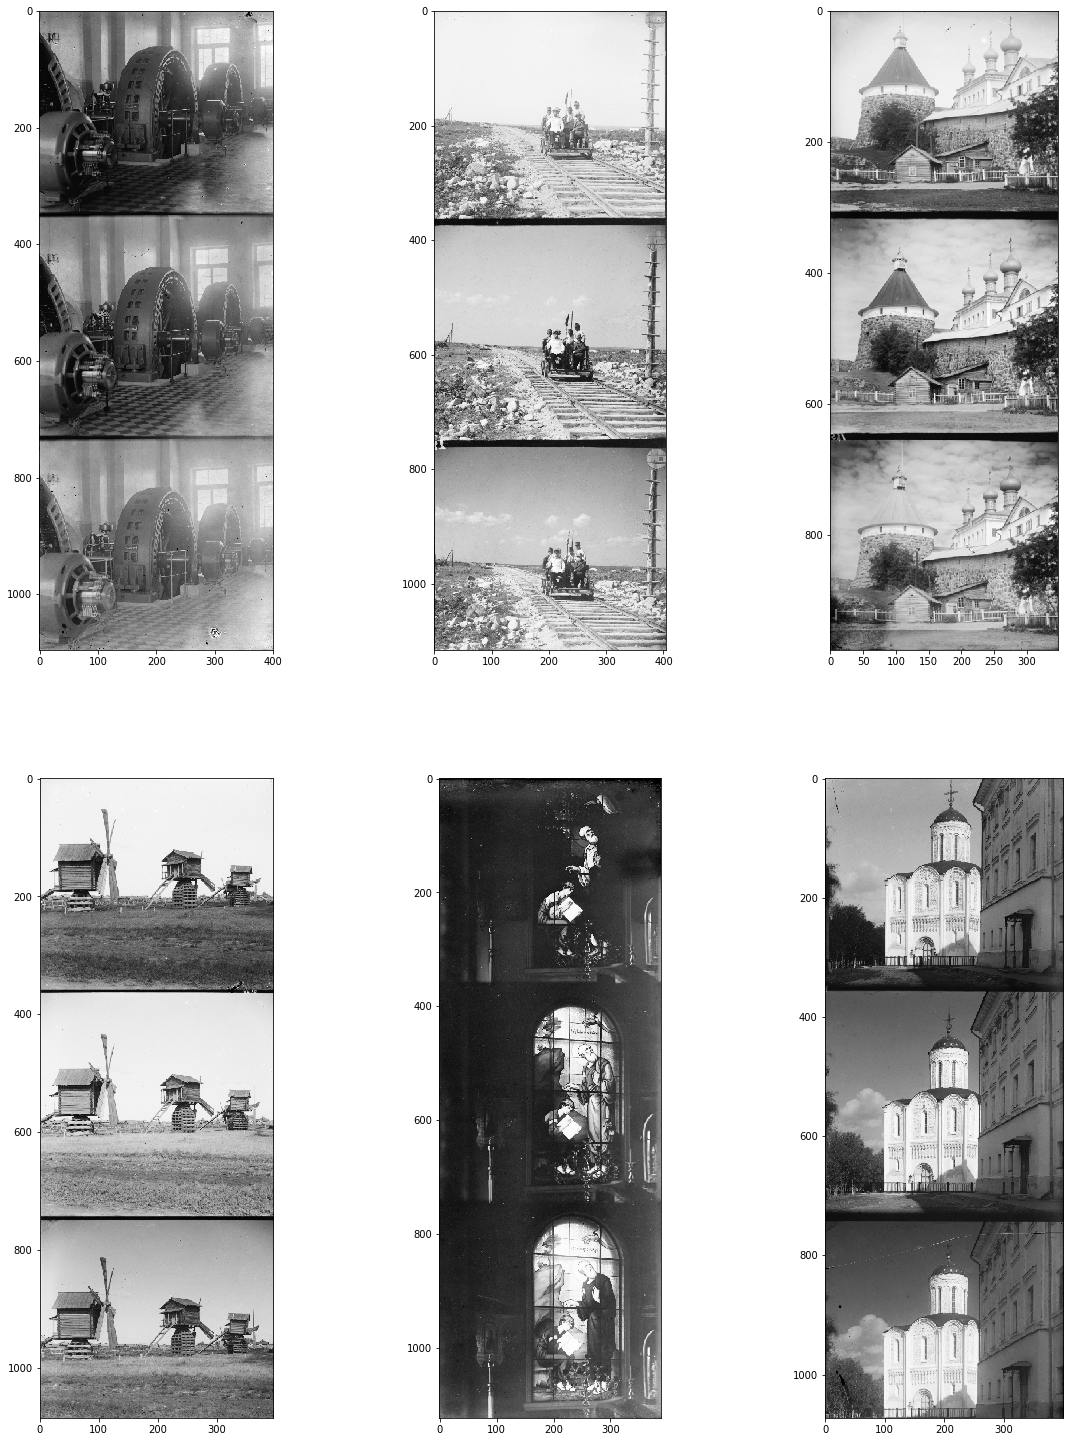

In [17]:
cropped_imgs = []
#crop borders
for i, img in enumerate(plates):
    print(i,'-th image:')
    cropped_imgs.append(remove_bordersV2(img, canny_imgs[i]))

visualize(cropped_imgs, 'gray')

#### Channels separation 

The next step is to separate the image into three channels (B, G, R) and make one colored picture. To get channels, we can divide each plate into three equal parts.

#################################################################

TODO: 

implement the function impose_components transforming   
cropped black-and-white images cropped_imgs             
into the list of RGB images rgb_imgs                    

#################################################################

In [18]:
def impose_components(img):
    nrows = img.shape[0]//3
    print('rows:',nrows)
    blue=img[0:nrows]
    green=img[nrows:2*nrows]
    red=img[2*nrows:3*nrows]
    print('blue shape:',blue.shape,'green shape:',green.shape,'red shape:',red.shape)
    imposed_img=np.stack([red,green,blue],axis=0) 
    
    return imposed_img

rows: 365
blue shape: (365, 401) green shape: (365, 401) red shape: (365, 401)
rows: 372
blue shape: (372, 405) green shape: (372, 405) red shape: (372, 405)
rows: 325
blue shape: (325, 348) green shape: (325, 348) red shape: (325, 348)
rows: 361
blue shape: (361, 396) green shape: (361, 396) red shape: (361, 396)
rows: 374
blue shape: (374, 389) green shape: (374, 389) red shape: (374, 389)
rows: 357
blue shape: (357, 400) green shape: (357, 400) red shape: (357, 400)


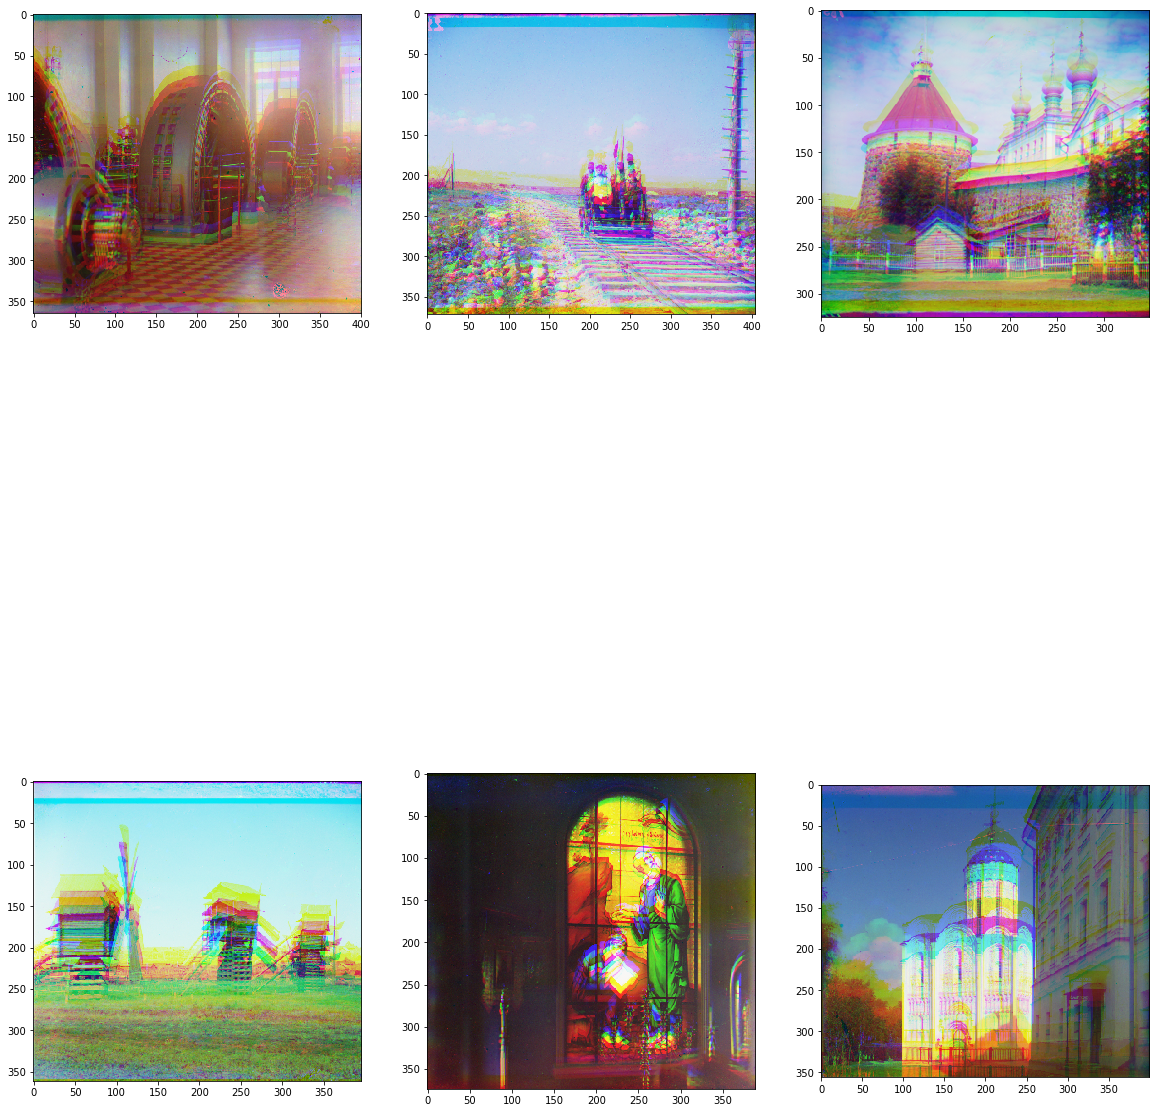

In [19]:
rgb_imgs = []
for cropped_img in cropped_imgs:
    rgb_img = impose_components(cropped_img)
    rgb_imgs.append(rgb_img)

visualize(rgb_imgs)

#### Search for the best shift for channel alignment 

In order to align two images, we will shift one image relative to another within some limits (e.g. from $-15$ to $15$ pixels). For each shift, we can calculate some metrics in the overlap of the images. Depending on the metrics, the best shift is the one the metrics achieves the greatest or the smallest value for. We should implement two metrics and choose the one that allows to obtain the better alignment quality:

* *Mean squared error (MSE):*<br><br>
$$ MSE(I_1, I_2) = \dfrac{1}{w * h}\sum_{x,y}(I_1(x,y)-I_2(x,y))^2, $$<br> where *w, h* are width and height of the images, respectively. To find the optimal shift you should find the minimum MSE over all the shift values.
    <br><br>
* *Normalized cross-correlation (CC):*<br><br>
    $$
    I_1 \ast I_2 = \dfrac{\sum_{x,y}I_1(x,y)I_2(x,y)}{\sum_{x,y}I_1(x,y)\sum_{x,y}I_2(x,y)}.
    $$<br>
    To find the optimal shift you should find the maximum CC over all the shift values.

09.25.2020

#################################################################

TODO: 

implement the functions mse & cor calculating           
mean squared error and normalized cross-correlation     
for two input images, respectively             

#################################################################

In [20]:
def mse(X, Y):
    return np.mean(np.square(X-Y))

def cor(X, Y):
    return np.sum(X*Y)/(np.sum(X)*np.sum(Y))

#################################################################
 
TODO: 

implement the algorithm to find the best channel        
shift and the alignment. Apply this algorithm for       
rgb_imgs processing and get the final list of colored   
pictures. These images will be used for the evaluation  
of the quality of the whole algorithm.        
                                                               
We can use the following interface or write your own.  

#################################################################

In [21]:
def get_best_shift_mse(channel1, channel2):
    
    nrows, ncols = channel2.shape
    shift_range = 15
    min_mse = mse(channel1,channel2)
    best_channel2 = np.copy(channel2)
    
    for dr in range(-shift_range,shift_range+1):
        for dc in range(-shift_range,shift_range+1):
            
            M = np.float64([[1,0,dr],[0,1,dc]])
            tmp_channel2 = cv2.warpAffine(channel2, M, (ncols, nrows))
            tmp_mse = mse(channel1, tmp_channel2)
            
            if (tmp_mse<min_mse):
                best_channel2 = np.copy(tmp_channel2)
                min_mse = tmp_mse
                
    return best_channel2

In [22]:
def get_best_shift_cor(channel1, channel2):
    
    nrows, ncols = channel2.shape
    shift_range = 15
    max_cor = cor(channel1,channel2)
    best_channel2 = np.copy(channel2)
    
    for dr in range(-shift_range,shift_range):
        for dc in range(-shift_range,shift_range):
            
            M = np.float64([[1,0,dr],[0,1,dc]])
            tmp_channel2 = cv2.warpAffine(channel2, M, (ncols, nrows))
            tmp_cor = cor(channel1, tmp_channel2)
            
            if (tmp_cor>max_cor):
                best_channel2 = np.copy(tmp_channel2)
                max_cor = tmp_cor
                
    return best_channel2

In [23]:
def get_best_shifts(channel1,channel2,metrics,shift_range):
    
    best_cor=cor(channel1,channel2)
    best_mse=mse(channel1,channel2)
    best_shift_r,best_shift_c=0,0
    
    for dr in range(-shift_range,shift_range+1):
        for dc in range(-shift_range,shift_range+1):
            
            if dr==0 and dc==0:
                continue
            
            channel1_r_start=max(dr,0)
            channel1_r_end=dr if dr<0 else None
            channel2_r_start=max((-1)*dr,0)
            channel2_r_end=None if dr<=0 else dr*(-1) 
            
            channel1_c_start=max(dc,0)
            channel1_c_end=dc if dc<0 else None
            channel2_c_start=max((-1)*dc,0)
            channel2_c_end=None if dc<=0 else dc*(-1) 
            
            channel1_shift=channel1[channel1_r_start:channel1_r_end,channel1_c_start:channel1_c_end]
            channel2_shift=channel2[channel2_r_start:channel2_r_end,channel2_c_start:channel2_c_end]
            
            if metrics=='mse':
                tmp_mse=mse(channel1_shift,channel2_shift)
                if (tmp_mse<best_mse):
                    best_mse=tmp_mse
                    best_shift_r=dr
                    best_shift_c=dc
                    
            elif metrics=='cor':
                tmp_cor=cor(channel1_shift,channel2_shift)
                if (tmp_corr>best_corr):
                    best_corr=tmp_corr
                    best_shift_r=dr
                    best_shift_c=dc
                    
            else:
                print('!!! provide a metrics, please !!!')
                break
                
    print('\tbest shift in r:',best_shift_r,'best shift in c:',best_shift_c)
                    
    return best_shift_r,best_shift_c

In [24]:
def get_best_image(rgb_img):
    
    print('RGB image shape:',rgb_img.shape)
    
    channel1 = rgb_img[0,:,:]
    channel2 = rgb_img[1,:,:]
    channel3 = rgb_img[2,:,:]
    
    print('\tchannel 1 shape:',channel1.shape,'channel 2 shape:',channel2.shape,'channel 3 shape:',channel3.shape)
    
    best_channel12 = get_best_shift_mse(channel1,channel2)
    best_channel13 = get_best_shift_mse(channel1,channel3)
    
    print('\tchannel 1&2 shape:',best_channel12.shape,'channel 1&3 shape:',best_channel13.shape)
    
    best_img = np.zeros(rgb_img.shape)
    best_img[0,:,:] = np.copy(channel1)
    best_img[1,:,:] = np.copy(best_channel12)
    best_img[2,:,:] = np.copy(best_channel13)
    best_img = np.copy(rgb_img)
    
    return best_img

In [25]:
def get_best_channel_corrections(channel1,channel2,channel3,metrics,shift_range):
    
    dr,dc=get_best_shifts(channel1,channel2,metrics,shift_range)
    
    channel1_r_start=max(dr,0)
    channel1_r_end=dr if dr<0 else None
    channel2_r_start=max((-1)*dr,0)
    channel2_r_end=None if dr<=0 else dr*(-1) 
            
    channel1_c_start=max(dc,0)
    channel1_c_end=dc if dc<0 else None
    channel2_c_start=max((-1)*dc,0)
    channel2_c_end=None if dc<=0 else dc*(-1)
    
    channel1_shift=channel1[channel1_r_start:channel1_r_end,channel1_c_start:channel1_c_end]
    channel2_shift=channel2[channel2_r_start:channel2_r_end,channel2_c_start:channel2_c_end]
    channel3_shift=channel3[channel2_r_start:channel2_r_end,channel2_c_start:channel2_c_end]
    
    channel_shift_avg=(channel1_shift+channel2_shift)/2
    dr2,dc2=get_best_shifts(channel3_shift,channel_shift_avg,metrics,shift_range)
    
    channel3_r_start=max(dr2,0)
    channel3_r_end=dr2 if dr2<0 else None
    channel2_r_start=max((-1)*dr2,0)
    channel2_r_end=None if dr2<=0 else dr2*(-1) 
            
    channel3_c_start=max(dc2,0)
    channel3_c_end=dc2 if dc2<0 else None
    channel2_c_start=max((-1)*dc2,0)
    channel2_c_end=None if dc2<=0 else dc2*(-1)
    
    channel3_shift=channel3[channel3_r_start:channel3_r_end,channel3_c_start:channel3_c_end]
    channel2_shift=channel2[channel2_r_start:channel2_r_end,channel2_c_start:channel2_c_end]
    channel1_shift=channel1[channel2_r_start:channel2_r_end,channel2_c_start:channel2_c_end]
    
    print('\t\tchannel 1 shift shape:',channel1_shift.shape,'channel 2 shift shape:',
          channel2_shift.shape,'channel 3 shift shape:',channel3_shift.shape)
    
    return channel1_shift,channel2_shift,channel3_shift

In [26]:
def get_best_imageV2(rgb_img,metrics):
    
    channel1,channel2,channel3=rgb_img
    print('channel 1 shape:',channel1.shape,'channel 2 shape:',channel2.shape,'channel 3 shape:',channel3.shape)
    
    corr_channel1,corr_channel2,corr_channel3=get_best_channel_corrections(channel1,channel2,channel3,'mse',15)
    corr_channel2,corr_channel3,corr_channel1=get_best_channel_corrections(corr_channel2,corr_channel3,corr_channel1,'mse',10)
    corr_channel3,corr_channel1,corr_channel2=get_best_channel_corrections(corr_channel3,corr_channel1,corr_channel2,'mse',5)
    
    return np.stack([corr_channel1,corr_channel2,corr_channel3],axis=0)

channel 1 shape: (365, 401) channel 2 shape: (365, 401) channel 3 shape: (365, 401)
	best shift in r: 13 best shift in c: -1
	best shift in r: -13 best shift in c: 1
		channel 1 shift shape: (352, 400) channel 2 shift shape: (352, 400) channel 3 shift shape: (352, 400)
	best shift in r: 0 best shift in c: 0
	best shift in r: 10 best shift in c: -1
		channel 1 shift shape: (342, 399) channel 2 shift shape: (342, 399) channel 3 shift shape: (342, 399)
	best shift in r: -3 best shift in c: 0
	best shift in r: -3 best shift in c: 0
		channel 1 shift shape: (339, 399) channel 2 shift shape: (339, 399) channel 3 shift shape: (339, 399)
channel 1 shape: (372, 405) channel 2 shape: (372, 405) channel 3 shape: (372, 405)
	best shift in r: 9 best shift in c: 1
	best shift in r: -15 best shift in c: -1
		channel 1 shift shape: (357, 404) channel 2 shift shape: (357, 404) channel 3 shift shape: (357, 404)
	best shift in r: 1 best shift in c: 0
	best shift in r: 10 best shift in c: 1
		channel 1 sh

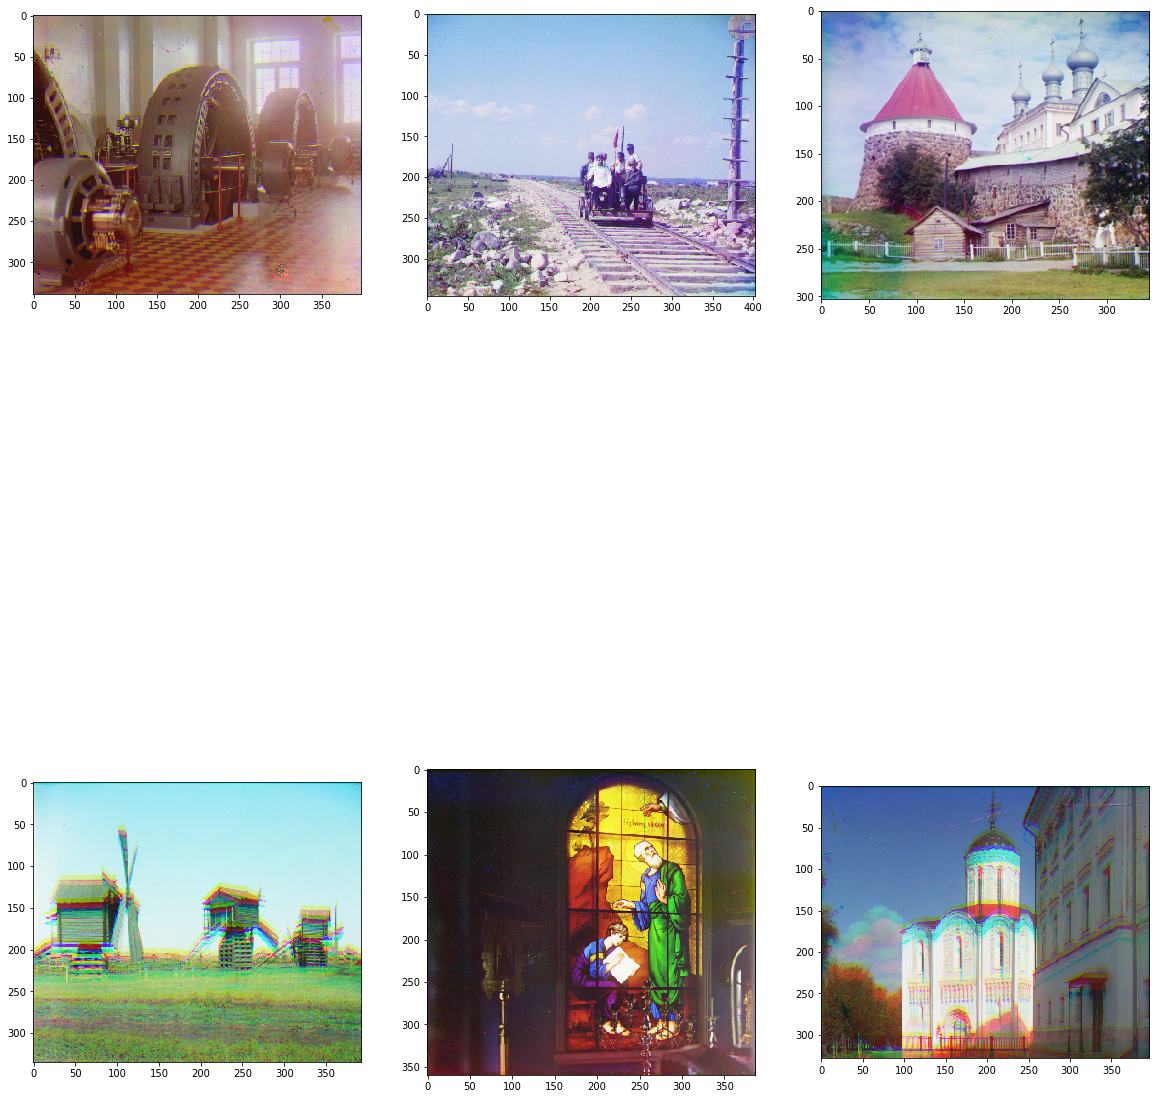

In [27]:
final_imgs = []
for img in rgb_imgs:
    final_img = get_best_imageV2(img,'mse')
    final_imgs.append(final_img)

visualize(final_imgs)

# Face Alignment 

In this task, we have to implement face normalization and alignment. Most of the face images deceptively seem to be aligned, but since many face recognition algorithms are very sensitive to shifts and rotations, we need not only to find a face on the image but also normalize it. Besides, the neural networks usually used for recognition have fixed input size, so, the normalized face images should be resized as well.

There are six images of faces we have to normalize. In addition, we have the coordinates of the eyes in each of the pictures. We have to rotate the image so that the eyes are on the same height, crop the square box containing the face and transform it to the size $224\times 224.$ The eyes should be located symmetrically and in the middle of the image (on the height).

#### Get data
We get the images and corresponding eyes coordinates for each person. We should implement the function $\tt{load}$\_$\tt{faces}$\_$\tt{and}$\_$\tt{eyes}$ that reads the data and returns two dictionaries: the dictionary of images and the dictionary of eyes coordinates. Eyes coordinates is a list of two tuples $[(x_1,y_1),(x_2,y_2)]$.
Both dictionaries should have filenames as the keys.

$\tt{dir}$\_$\tt{name}$ is the path to the directory with face images, $\tt{eye}$\_$\tt{path}$ is the path to .pickle file with eyes coordinates. If these directory and file are located in the same directory as this notebook, then default arguments can be used.

In [28]:
def load_faces_and_eyes(dir_name='faces_imgs', eye_path='./eyes.pickle'):
    
    eyes=pickle.load(open(eye_path, 'rb'))
    
    faces=dict()
    for image in os.listdir(dir_name):
        img=plt.imread(os.path.join(dir_name,image))
        faces[image]=img
        
    return faces, eyes

In [29]:
faces, eyes = load_faces_and_eyes()

Here is how the input images look like:

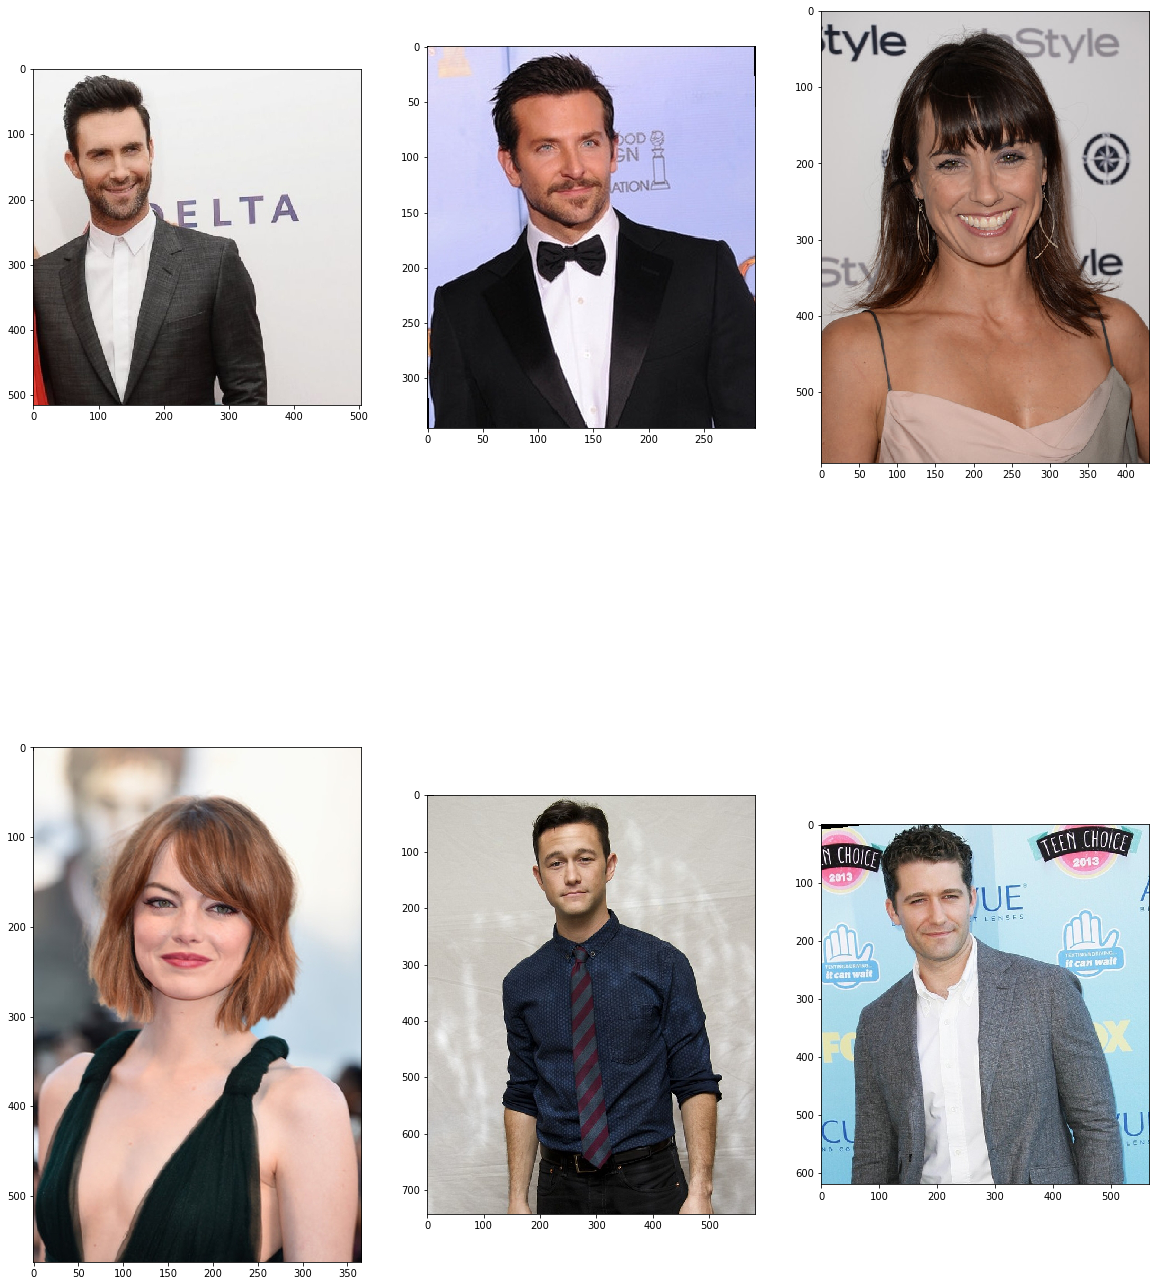

In [30]:
visualize(faces.values())

We may make the transformation using our own algorithm or by the following steps:
1. Find the angle between the segment connecting two eyes and horizontal line;
2. Rotate the image;
3. Find the coordinates of the eyes on the rotated image
4. Find the width and height of the box containing the face depending on the eyes coordinates
5. Crop the box and resize it to $224\times224$

#################################################################

TODO: 

implement the function transform_face that rotates      
the image so that the eyes have equal ordinate,         
crops the square box containing face and resizes it.    
You can use methods from skimage library if you need.   

#################################################################

In [33]:
def transform_face(image, eyes):
    
    # angle btw eyes & horizontal line
    le, re = eyes
    print('(left-eye, right-eye) =',eyes)
    row=(re[1]-le[1])*(-1)
    col=(re[0]-le[0])
    angle=math.acos(abs(row/math.sqrt(row**2+col**2)))
    if row>0: angle*=(-1)
        
    # rotate image around left-eye
    image_rotated=rotate(image,angle*(180/math.pi),center=eyes[0])
    
    # find new eye coordinates after rotation
    # translate image around left-eye
    le_1st_translation=tf.SimilarityTransform(translation=[-le[0],-le[1]])
    le_rotation=tf.SimilarityTransform(rotation=angle)
    le_2nd_translation=tf.SimilarityTransform(translation=le)
    
    re_transformation=le_2nd_translation(le_rotation([le_1st_translation(re)[0][0],(-1)*le_1st_translation(re)[0][1]]))
    print('\t',re_transformation)
    re_new_coordinate=tuple([int(np.ceil(re_transformation[0][0])),eyes[0][1]]) # (right-X, left-Y)
    
    # find width & height of the face enclosure box
    distance_eyes=re_new_coordinate[0]-le[0]
    
    # crop box and resize to 224*224
    image=image[le[1]-int(1.25*distance_eyes):le[1]+int(1.25*distance_eyes),
                le[0]-int(1.25*distance_eyes):re[0]+int(1.25*distance_eyes)]
        
    return image

(left-eye, right-eye) = [(104, 132), (152, 124)]
	 [[119.78230278  85.96828355]]
(left-eye, right-eye) = [(108, 92), (145, 88)]
	 [[115.95365638  55.64426661]]
(left-eye, right-eye) = [(173, 201), (246, 193)]
	 [[188.90477877 129.30594158]]
(left-eye, right-eye) = [(146, 174), (211, 180)]
	 [[157.94920015 238.17333259]]
(left-eye, right-eye) = [(230, 121), (279, 114)]
	 [[243.85929291  73.4824243 ]]
(left-eye, right-eye) = [(169, 133), (222, 126)]
	 [[182.87946714  81.37287155]]


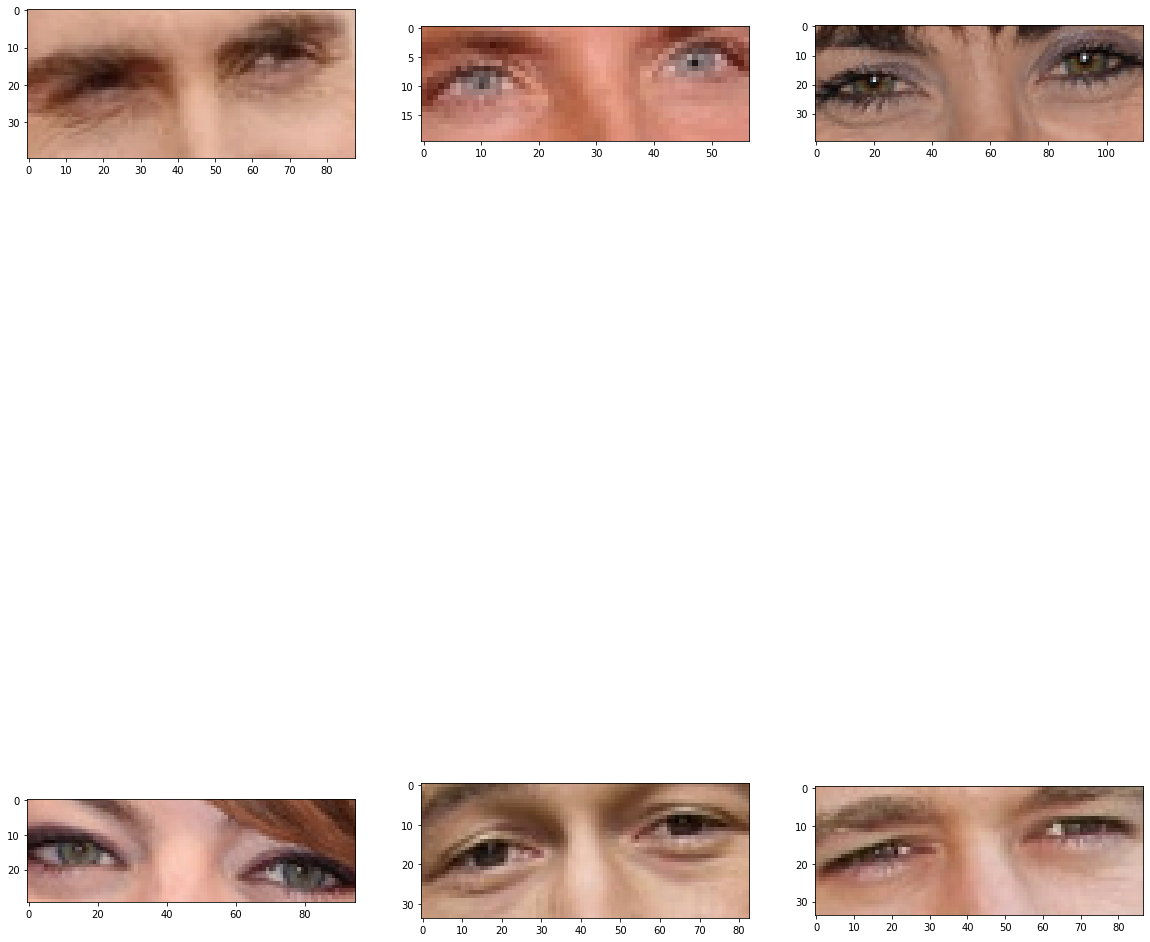

In [34]:
transformed_imgs = []
for i in faces:
    img = faces[i]
    eye = eyes[i]
    transformed = transform_face(img, eye)
    transformed_imgs.append(transformed)
    
visualize(transformed_imgs)